# Project ARI3205 Interpretable AI for Deep Learning Models *(Part 1.2)*
---

**Name:** Andrea Filiberto Lucas  
**ID No:** 0279704L

---

## Importing Necessary Libraries

In [16]:
# Check and install required libraries from the libraries.json file
import json

# Read the libraries from the text file
with open('../Libraries/Part1_Lib.json', 'r') as file:
    libraries = json.load(file)

# ANSI escape codes for colored output
GREEN = "\033[92m"  # Green text
RED = "\033[91m"    # Red text
RESET = "\033[0m"   # Reset to default color

# Function to check and install libraries
def check_and_install_libraries(libraries):
    for lib, import_name in libraries.items():
        try:
            # Attempt to import the library
            __import__(import_name)
            print(f"[{GREEN}✔{RESET}] Library '{lib}' is already installed.")
        except ImportError:
            # If import fails, try to install the library
            print(f"[{RED}✖{RESET}] Library '{lib}' is not installed. Installing...")
            %pip install {lib}

# Execute the function to check and install libraries
check_and_install_libraries(libraries)

# Import necessary libraries for data analysis and modeling
import warnings                                                                     # Disable warnings
import pandas as pd                                                                 # Data manipulation and analysis                #type: ignore
import numpy as np                                                                  # Numerical computations                        #type: ignore
import matplotlib.pyplot as plt                                                     # Data visualization                            #type: ignore
import seaborn as sns                                                               # Statistical data visualization                #type: ignore
import statsmodels.formula.api as smf                                               # Statistical models                            #type: ignore
from sklearn.model_selection import train_test_split                                # Train-test split                              #type: ignore
from tensorflow.keras.models import Sequential                                      # Neural network model                          #type: ignore
from tensorflow.keras.layers import Dense, Input                                    # Neural network layers                         #type: ignore                                                               
from tensorflow.keras.optimizers import Adam                                        # Neural network optimizer                      #type: ignore
from sklearn.preprocessing import StandardScaler,  OneHotEncoder                    # Data scaling                                  #type: ignore
from sklearn.impute import SimpleImputer                                            # Missing value imputation                      #type: ignore
from sklearn.inspection import PartialDependenceDisplay, permutation_importance     # Feature importance                            #type: ignore
from alibi.explainers import ALE, plot_ale                                          # ALE plots                                     #type: ignore
from sklearn.neural_network import MLPClassifier                                    # Neural network classifier                     #type: ignore
from sklearn.metrics import accuracy_score                                          # Model evaluation                              #type: ignore
import statsmodels.api as sm                                                        # Statistical models                            #type: ignore

# Suppress specific warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names") 
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

[✔] Library 'tensorflow' is already installed.
[✔] Library 'scikit-learn' is already installed.
[✔] Library 'matplotlib' is already installed.
[✔] Library 'seaborn' is already installed.
[✔] Library 'pandas' is already installed.
[✔] Library 'numpy' is already installed.
[✔] Library 'scipy' is already installed.
[✔] Library 'alibi' is already installed.


## General Information on Titanic Dataset
*https://www.kaggle.com/competitions/titanic/data*

In [17]:
# Define the filenames
train_filename = '../Datasets/Titanic/train.csv'
test_filename = '../Datasets/Titanic/test.csv'
gender_submission_filename = '../Datasets/Titanic/gender_submission.csv'

# Load the datasets
try:
    train_data = pd.read_csv(train_filename)
    test_data = pd.read_csv(test_filename)
    gender_submission_data = pd.read_csv(gender_submission_filename)
    print(f"'{train_filename}' dataset loaded successfully.")
    print(f"'{test_filename}' dataset loaded successfully.")
    print(f"'{gender_submission_filename}' dataset loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e.filename} was not found. Please ensure it is in the correct directory.")
    exit()
except pd.errors.EmptyDataError as e:
    print(f"Error: {e.filename} is empty.")
    exit()
except pd.errors.ParserError as e:
    print(f"Error: There was a problem parsing {e.filename}. Please check the file format.")
    exit()

# Dataset insights
print("\nTrain Dataset Overview:")
print(train_data.info())
print("\nTrain Dataset Statistical Summary:")
print(train_data.describe())

print("\nTest Dataset Overview:")
print(test_data.info())
print("\nTest Dataset Statistical Summary:")
print(test_data.describe())

print("\nGender Submission Dataset Overview:")
print(gender_submission_data.info())

'../Datasets/Titanic/train.csv' dataset loaded successfully.
'../Datasets/Titanic/test.csv' dataset loaded successfully.
'../Datasets/Titanic/gender_submission.csv' dataset loaded successfully.

Train Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

Train Dataset Stati

## Feed-Forward Neural Network

In [18]:
# Load the Titanic dataset
train_data = pd.read_csv('../Datasets/Titanic/train.csv')

# Preprocessing
# Separate features and target
y = train_data['Survived']  # Target
X = train_data.drop(columns=['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin'])  # Features

# Handle categorical variables with one-hot encoding
categorical_features = ['Sex', 'Embarked']
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_encoded = one_hot_encoder.fit_transform(X[categorical_features])
categorical_encoded_df = pd.DataFrame(categorical_encoded, columns=one_hot_encoder.get_feature_names_out(categorical_features))

# Drop original categorical columns and append the encoded columns
X = X.drop(columns=categorical_features)
X = pd.concat([X.reset_index(drop=True), categorical_encoded_df.reset_index(drop=True)], axis=1)

# Handle missing values with mean imputation
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Standardize the features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (712, 11)
Test data shape: (179, 11)


In [19]:
# Build the feed-forward neural network
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Define input shape explicitly
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4462 - loss: 0.7103 - val_accuracy: 0.7902 - val_loss: 0.6079
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7787 - loss: 0.5854 - val_accuracy: 0.8042 - val_loss: 0.5221
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7958 - loss: 0.5179 - val_accuracy: 0.8252 - val_loss: 0.4649
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7779 - loss: 0.4995 - val_accuracy: 0.8322 - val_loss: 0.4272
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8028 - loss: 0.4671 - val_accuracy: 0.8322 - val_loss: 0.4102
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7966 - loss: 0.4537 - val_accuracy: 0.8322 - val_loss: 0.3986
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7936 - loss: 0.4661 - val_accuracy: 0.8322 - val_loss: 0.3977
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8057 - loss: 0.4464 - val_accuracy: 0.8322 - val_loss:

## Surrogate Model - MLPClassifier

In [20]:
# Train a surrogate model (MLPClassifier)
surrogate_model = MLPClassifier(hidden_layer_sizes=(32,), activation='logistic', random_state=1, max_iter=1000).fit(X_train, y_train)
print('Accuracy (MLPClassifier): ' + str(surrogate_model.score(X_train, y_train)))

Accuracy (MLPClassifier): 0.800561797752809


## Partial Dependence Plots (PDP) and Individual Conditional Expectation (ICE) plots

In [21]:
# Partial Dependence Plots (PDP) Function
def plot_pdp(surrogate_model, X_train, features_to_analyze):
    print("\nGenerating Partial Dependence Plots (PDP) for features:", features_to_analyze)
    fig, ax = plt.subplots(1, len(features_to_analyze), figsize=(15, 6), constrained_layout=True)
    for i, feature in enumerate(features_to_analyze):
        PartialDependenceDisplay.from_estimator(
            surrogate_model,  # The trained surrogate model (RandomForestClassifier)
            X_train,  # Training data
            features=[X_train.columns.get_loc(feature)],  # Single feature for PDP
            kind="average",  # PDP only
            ax=ax[i] if len(features_to_analyze) > 1 else ax,
            grid_resolution=50,
        )
        ax[i].set_title(f"PDP for {feature}")
    plt.show()

In [22]:
# Individual Conditional Expectation (ICE) Plots Function
def plot_ice(surrogate_model, X_train, features_to_analyze):
    print("\nGenerating Individual Conditional Expectation (ICE) Plots for features:", features_to_analyze)
    fig, ax = plt.subplots(1, len(features_to_analyze), figsize=(15, 6), constrained_layout=True)
    for i, feature in enumerate(features_to_analyze):
        PartialDependenceDisplay.from_estimator(
            surrogate_model,  # The trained surrogate model (RandomForestClassifier)
            X_train,  # Training data
            features=[X_train.columns.get_loc(feature)],  # Single feature for ICE
            kind="both",  # PDP and ICE
            ax=ax[i] if len(features_to_analyze) > 1 else ax,
            grid_resolution=50,
        )
        ax[i].set_title(f"ICE and PDP for {feature}")
    plt.show()

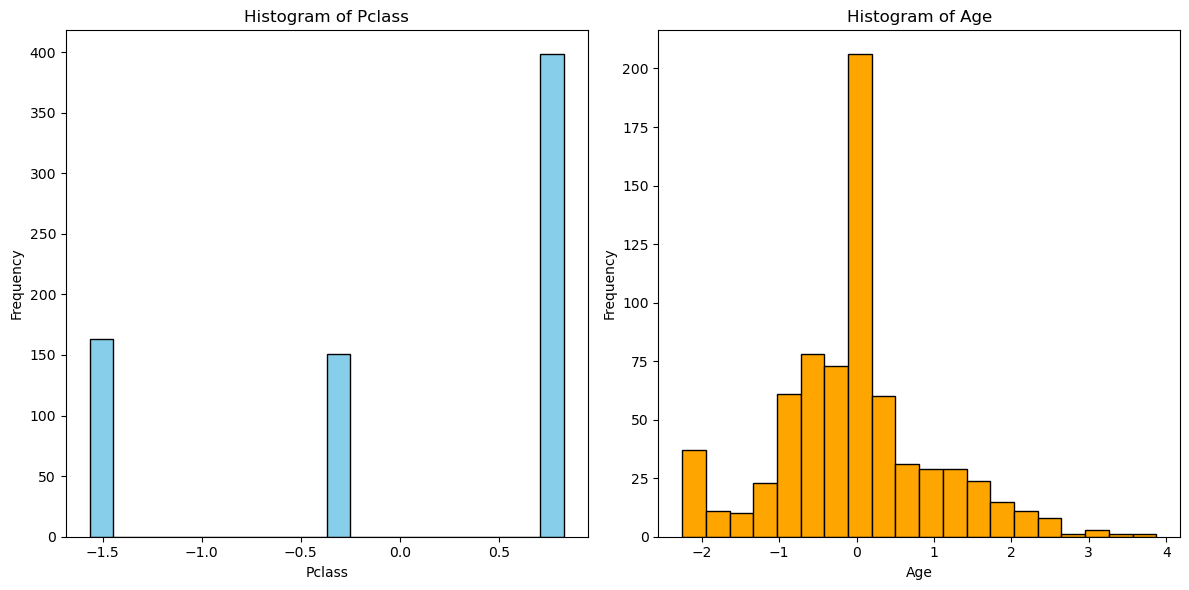


Generating Partial Dependence Plots (PDP) for features: ['Pclass', 'Age']


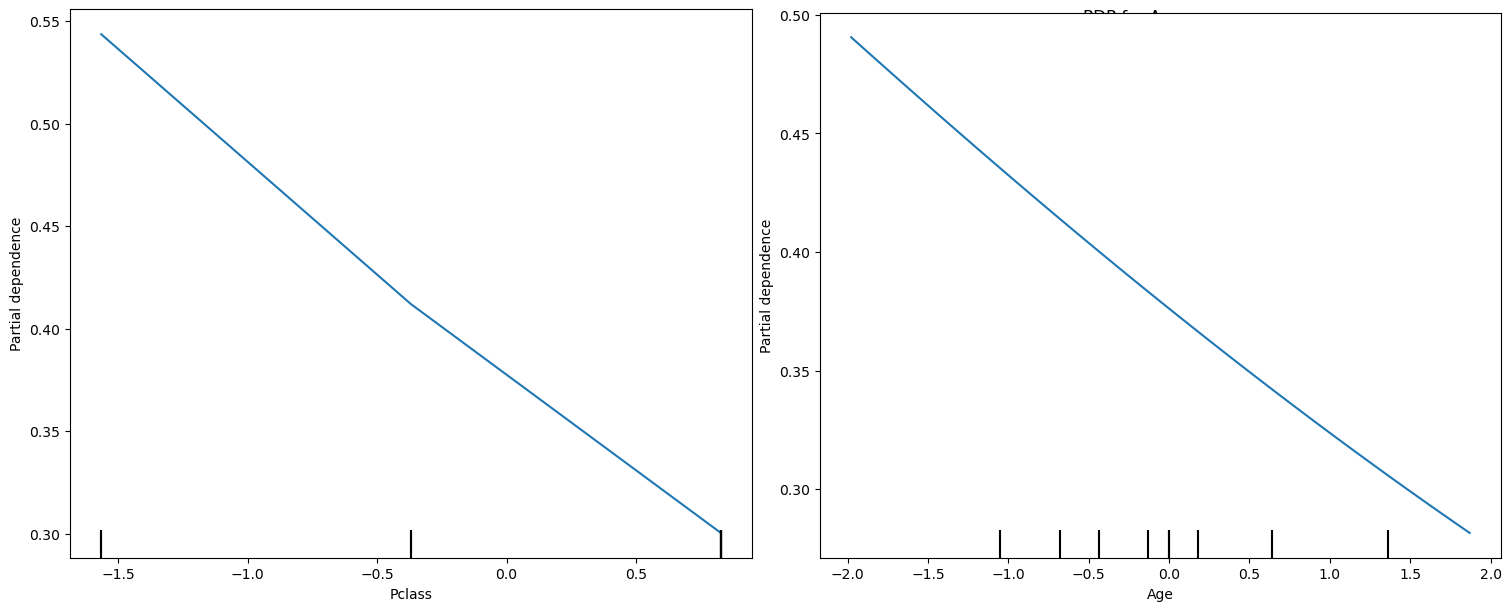


Generating Individual Conditional Expectation (ICE) Plots for features: ['Pclass', 'Age']


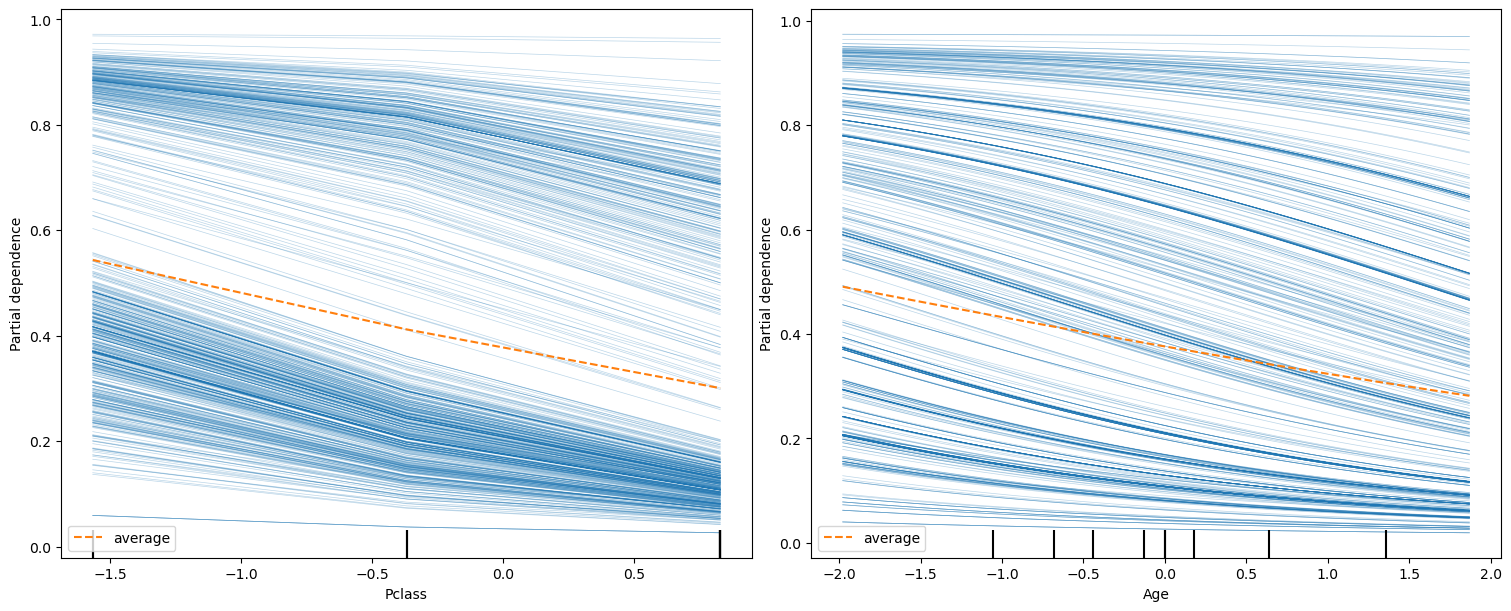

In [23]:
# Call PDP and ICE plot functions
features_to_analyze = ["Pclass", "Age"]

# Plot histograms for features_to_analyze
plt.figure(figsize=(12, 6))
for i, feature in enumerate(features_to_analyze):
    plt.subplot(1, len(features_to_analyze), i + 1)
    plt.hist(X_train[feature], bins=20, edgecolor='black', color='skyblue' if i % 2 == 0 else 'orange')
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

plot_pdp(surrogate_model, X_train, features_to_analyze)
plot_ice(surrogate_model, X_train, features_to_analyze)

The variables `Pclass` (passenger class) and `Age` were chosen for their relevance in modeling survival outcomes on the Titanic dataset. `Pclass` is a categorical variable that captures the socioeconomic status of passengers, an essential factor influencing survival probability during a disaster. Historically, passengers in higher classes often had better access to lifeboats and safety provisions, making this variable critical for understanding survival disparities. On the other hand, `Age` represents an individual's stage of life, directly tied to survival priorities during emergencies, where children and younger individuals might be given precedence in rescue efforts.

#### Insights from Partial Dependence Plots (PDPs)
The **PDPs** for `Pclass` and `Age` reveal distinct global trends in their relationship with the predicted survival probability. The PDP for `Pclass` shows a **negative monotonic trend**, indicating that higher classes (lower numeric values in `Pclass`) are associated with increased survival probabilities. This aligns with the historical context of the Titanic disaster, where first-class passengers had better access to lifeboats compared to those in third class. Similarly, the PDP for `Age` displays a **negative relationship** with survival probability, where younger passengers, especially children, had a higher likelihood of survival. This trend reflects the "women and children first" policy that was partly followed during the evacuation.

While PDPs provide a useful global perspective, they average the effects across all passengers, which can obscure individual variations or interactions between features.

#### Insights from Individual Conditional Expectation (ICE) Plots
The **ICE plots** add granularity to the PDP analysis by showing how `Pclass` and `Age` affect the survival probability for individual passengers. For `Pclass`, the ICE plots reveal consistent negative slopes for most passengers, confirming that higher classes are universally beneficial for survival. However, there are slight deviations in the slopes, indicating that the effect of `Pclass` might vary slightly for certain individuals, potentially due to interactions with other features like `Sex` or `SibSp`.

The ICE plots for `Age` similarly show a predominantly negative trend, where survival probability decreases with increasing age. However, individual instances exhibit variability, with some passengers showing less sensitivity to age changes. For instance, middle-aged passengers in specific contexts may experience a smaller decline in survival probability compared to those in lower classes.

#### Combined Insights and Key Takeaways
The analysis highlights the critical role of both `Pclass` and `Age` in determining survival outcomes. PDPs provide a **broad average perspective**, confirming the overall trends: higher socioeconomic status and younger age improve survival probabilities. Meanwhile, ICE plots uncover **individual-level nuances**, showcasing heterogeneity in how these variables impact survival across different passengers.

By combining PDPs and ICE plots, we gain a comprehensive understanding of the model's behavior. `Pclass` strongly reflects the structural inequalities during the Titanic disaster, while `Age` emphasizes the prioritization of specific demographic groups. These insights ensure the interpretability of the model and help align its predictions with historical and contextual expectations.

## Permutation Feature Importance (PFI)

In [24]:
# Compute Permutation Feature Importance
def compute_pfi(model, X_test, y_test, feature_names):
    pfi_result = permutation_importance(
        model, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy'
    )

    # Convert PFI results into a DataFrame for better visualization
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': pfi_result.importances_mean,
        'Std': pfi_result.importances_std
    })

    # Sort features by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print("\nPermutation Feature Importance:\n", importance_df)
    return importance_df

In [25]:
# Plot Permutation Feature Importance as a Boxplot
def plot_pfi(model, X_test, y_test, feature_names):
    result = permutation_importance(
        model, X_test, y_test, scoring='accuracy', n_repeats=10, random_state=42, n_jobs=2
    )

    sorted_importances_idx = result.importances_mean.argsort()
    importances = pd.DataFrame(
        result.importances[sorted_importances_idx].T,
        columns=[feature_names[i] for i in sorted_importances_idx]
    )

    ax = importances.plot.box(
        vert=False, whis=10, figsize=(12, 8),
        color=dict(boxes="blue", whiskers="black", medians="green", caps="black")
    )
    ax.axvline(x=0, color="k", linestyle="--")

    # Add faint grey lines across the graph for each feature
    for i in range(len(importances.columns)):
        plt.axhline(y=i + 1, color="grey", linestyle="-", linewidth=0.5, alpha=0.5)

    # Add faint grey lines upwards from the x-axis ticks
    xticks = ax.get_xticks()
    for tick in xticks:
        plt.axvline(x=tick, color="grey", linestyle="-", linewidth=0.5, alpha=0.5)
    
    # Set the x-axis limits
    ax.set_xlim(left=0 - 0.5 * (ax.get_xlim()[1] - 0))

    # Set the x-axis limits
    ax.set_xlabel("Decrease in Accuracy")
    ax.set_ylabel("Feature")
    ax.set_title("Permutation Feature Importance")
    plt.tight_layout()
    plt.show()


Permutation Feature Importance:
          Feature  Importance       Std
5     Sex_female    0.045251  0.011571
6       Sex_male    0.031285  0.014177
1            Age    0.021788  0.009497
2          SibSp    0.005028  0.005270
0         Pclass    0.003911  0.013232
8     Embarked_Q    0.000000  0.000000
10  Embarked_nan    0.000000  0.000000
9     Embarked_S   -0.003911  0.003577
7     Embarked_C   -0.004469  0.002235
3          Parch   -0.005028  0.001676
4           Fare   -0.006145  0.008815


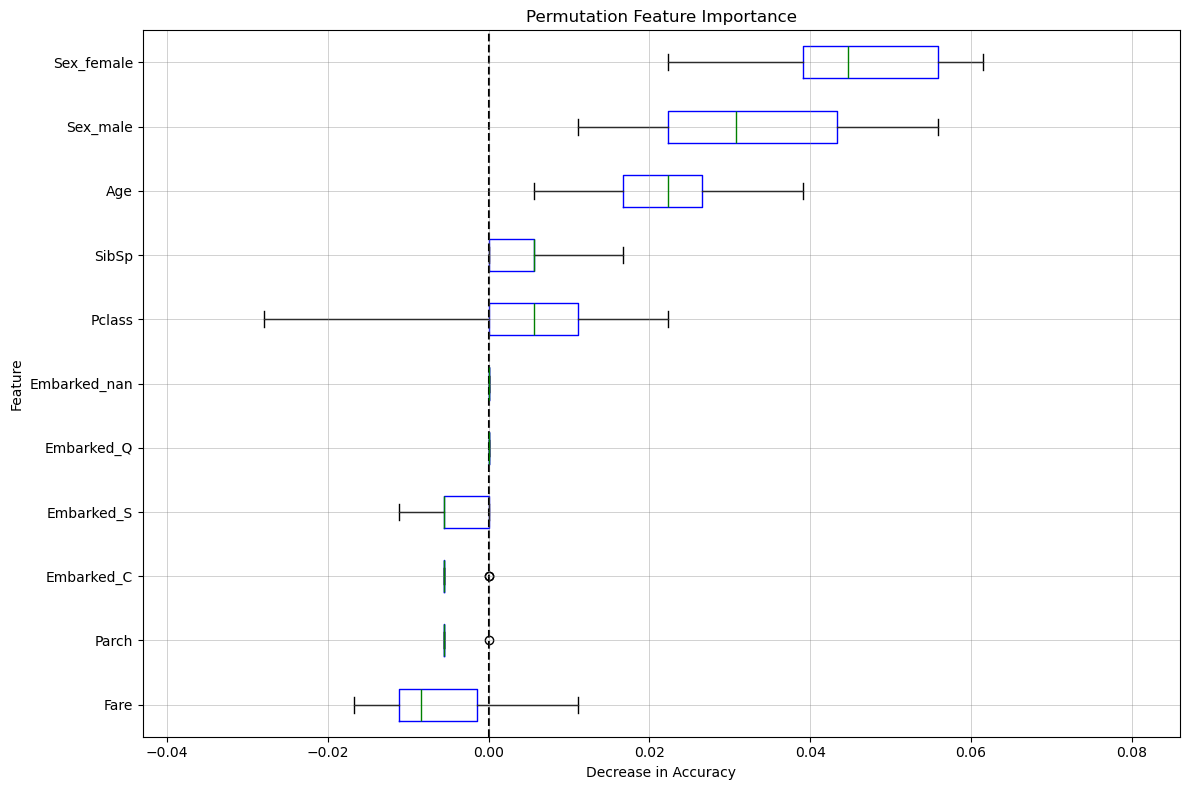

In [26]:
feature_names = X_test.columns
importance_df = compute_pfi(surrogate_model, X_test, y_test, feature_names)
plot_pfi(surrogate_model, X_test, y_test, feature_names)

### Permutation Feature Importance Results

The **Permutation Feature Importance (PFI)** results, visualized in the boxplot above, highlight the relative contributions of each feature to the model's predictive performance for Titanic survival outcomes. `Sex_female` is identified as the most critical feature, with a mean importance score of 0.045 and a standard deviation of 0.012. This underscores its significant influence on survival predictions, reflecting historical biases in rescue operations that prioritized women and children. The second most influential feature is `Sex_male`, with an importance score of 0.031 and a higher standard deviation of 0.014, reinforcing the strong yet slightly less consistent impact of gender on survival probabilities.

The variable `Age` follows as the third most important feature, with an importance score of 0.022 and a lower standard deviation of 0.009, reflecting its consistent influence on survival. Younger individuals, especially children, were often prioritized, aligning with historical records. The variables `SibSp` (number of siblings/spouses aboard) and `Pclass` (passenger class) show lower importance scores of 0.005 and 0.004, respectively, suggesting their more limited, yet still meaningful, impact on survival outcomes. These results align with expectations that family connections and class influenced access to lifeboats, albeit less strongly than gender or age.

Interestingly, features such as `Embarked_C`, `Embarked_S`, and `Fare` exhibit negative importance scores, implying that their randomization slightly improved the model's performance. This suggests that these features may introduce noise or have weak or non-linear relationships with the target variable. The variables `Embarked_Q` and `Embarked_nan` have zero importance, indicating no measurable effect on the model’s predictions.

The boxplot further highlights variability in feature importance scores across permutations. Features like `Sex_female` and `Age` exhibit tight whiskers, indicating consistent importance across permutations, while features such as `Pclass` display more variability, reflecting context-dependent effects.

### Explain what the term “important” means when using the PFI method.

In the context of PFI, **importance** measures the extent to which a feature contributes to the model’s predictive accuracy. This is quantified by observing the increase (or decrease) in error when a feature's values are randomly permuted while keeping all other features constant. A high importance score suggests that the feature provides critical information for predictions, as its randomization significantly degrades the model's performance. Conversely, a low or negative score implies that the feature's contribution is minimal or may even act as noise.

For the current results, the high importance scores of `Sex_female` and `Sex_male` highlight their dominant roles in capturing survival disparities based on gender. The consistent importance of `Age` reflects the prioritization of younger individuals in survival efforts. On the other hand, the negligible or negative importance scores for features like `Embarked_C` and `Fare` suggest that these variables either contribute weakly to the model or may have indirect or non-linear relationships with survival. The PFI results thus offer a nuanced understanding of feature relevance, capturing both their direct and indirect effects on model performance.

## Accumulated Local Effects (ALE)

In [27]:
# Combine features and target for context if needed
data = pd.concat([X_train, y_train], axis=1)

# Define feature names
feature_names = X_train.columns

# Ensure valid input for ALE explainer
X_train_array = X_train.to_numpy()  # Convert to NumPy array to avoid warnings

# Create and compute ALE explainer
ale_explainer = ALE(surrogate_model.predict, feature_names=feature_names)
ale_explanation = ale_explainer.explain(X_train_array)

array([[<Axes: xlabel='Pclass', ylabel='ALE'>,
        <Axes: xlabel='Age', ylabel='ALE'>]], dtype=object)

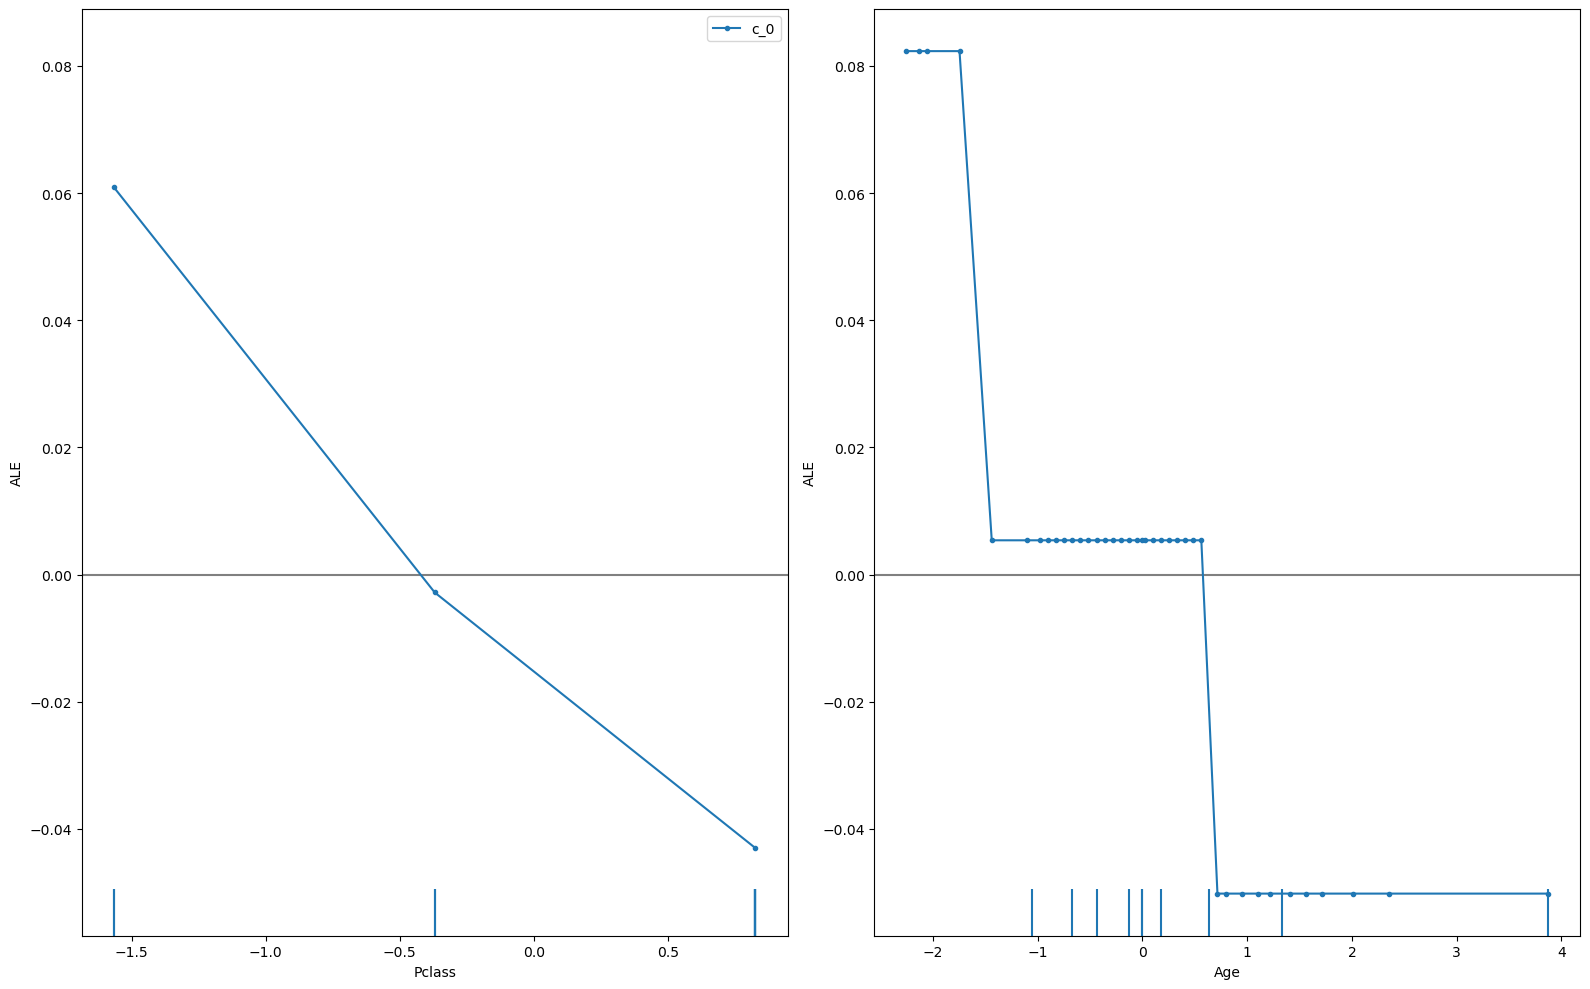

In [28]:
# Plot ALE for selected features
plot_ale(
    ale_explanation,
    features=["Pclass", "Age"],  # Select specific features
    n_cols=2,  # Arrange plots in 2 columns for better visualization
    fig_kw={'figwidth': 16, 'figheight': 10}  # Adjust figure size for clarity
)

### Comparing ALE and PDP for `Pclass` and `Age`

The **Accumulated Local Effects (ALE)** plots and **Partial Dependence Plots (PDPs)** provide complementary perspectives on the model’s behavior in predicting Titanic survival outcomes. Both tools aim to interpret the influence of features on the model, but their methodologies highlight distinct aspects of the relationships between the features and the predictions.

#### Accumulated Local Effects (ALE)
The ALE plots for `Pclass` and `Age` reveal localized trends in how these features impact survival probabilities. For `Pclass`, the ALE plot shows a strong negative relationship, where survival likelihood decreases as passenger class increases (lower numeric values indicate higher classes, with 1 being the first class). The steep decline emphasizes the significant advantage of being in a higher class, reflecting historical rescue priorities where first-class passengers were more likely to survive.

Similarly, for `Age`, the ALE plot demonstrates a sharp and non-linear relationship. Younger passengers (negative standardized values) have markedly higher survival probabilities, with the effect dropping abruptly for older passengers. This aligns with real-world events where younger individuals, particularly children, were given priority during rescue operations. The localized approach of ALE highlights the sharp transitions in survival probabilities for specific age ranges, offering a nuanced understanding of the model’s behavior.

#### Partial Dependence Plots (PDPs)
The PDPs for `Pclass` and `Age` provide a global perspective on feature effects. For `Pclass`, the PDP similarly shows a negative trend, reinforcing the inverse relationship between class and survival likelihood. However, the smoothness of the PDP masks localized variations and interactions that are evident in the ALE plot. For instance, the PDP averages the impact of passenger class across all data points, potentially smoothing out critical distinctions between specific class ranges.

The PDP for `Age` highlights a consistent decline in survival probabilities as age increases, with younger passengers exhibiting higher survival rates. While this trend aligns with the ALE results, the PDP’s global averaging approach fails to capture the sharp transitions and localized effects observed in the ALE plot, such as the steep drop-off for specific age groups.

#### Key Differences and Insights
The primary distinction between ALE and PDP lies in their interpretability. The ALE plots provide a localized view of feature effects, offering insights into the variations within specific ranges of the features. This is particularly valuable for understanding sharp transitions or non-linear relationships, such as the significant drop in survival probabilities for older passengers or the steep decline in survival likelihood with increasing `Pclass`.

In contrast, PDPs offer a broader, global perspective by averaging the effects across all instances. While they provide a straightforward summary of feature relationships, they may obscure localized nuances and interactions, as seen in the smoother trends for both `Pclass` and `Age`.

#### Key Takeaways
Both ALE and PDP agree on the general trends for `Pclass` and `Age`: higher-class passengers and younger individuals have better survival outcomes. However, the ALE plots add depth by revealing localized behaviors and sharp transitions that the PDPs overlook. Together, these tools provide a comprehensive understanding of the model’s behavior, with PDPs offering an accessible overview and ALE enhancing interpretability by uncovering detailed, localized effects.

## Global Surrogates

In [29]:
# Get predictions from the neural network surrogate model
NN_labels = surrogate_model.predict(X_train)
X_train['NN_labels'] = NN_labels

# Prepare formula for logistic regression analysis
all_columns = " + ".join([f"Q('{col}')" for col in X_train.columns[:-1]])  # Exclude NN_labels
my_formula = f"NN_labels ~ {all_columns}"

# Train logistic regression surrogate model
logistic = smf.glm(formula=my_formula, family=sm.families.Binomial(), data=X_train).fit()
print(logistic.summary())

# Predict using the logistic regression model
y_pred = logistic.predict(X_train)
y_class = [0 if x < 0.5 else 1 for x in y_pred]

# Calculate accuracy of the surrogate model
score = accuracy_score(y_class, X_train['NN_labels'])
print(f"Logistic Regression Surrogate Accuracy: {score}")

                 Generalized Linear Model Regression Results                  
Dep. Variable:              NN_labels   No. Observations:                  712
Model:                            GLM   Df Residuals:                      702
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Fri, 17 Jan 2025   Deviance:                   3.9547e-09
Time:                        17:08:46   Pearson chi2:                 1.98e-09
No. Iterations:                    31   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          -283.3624    7.7e+0

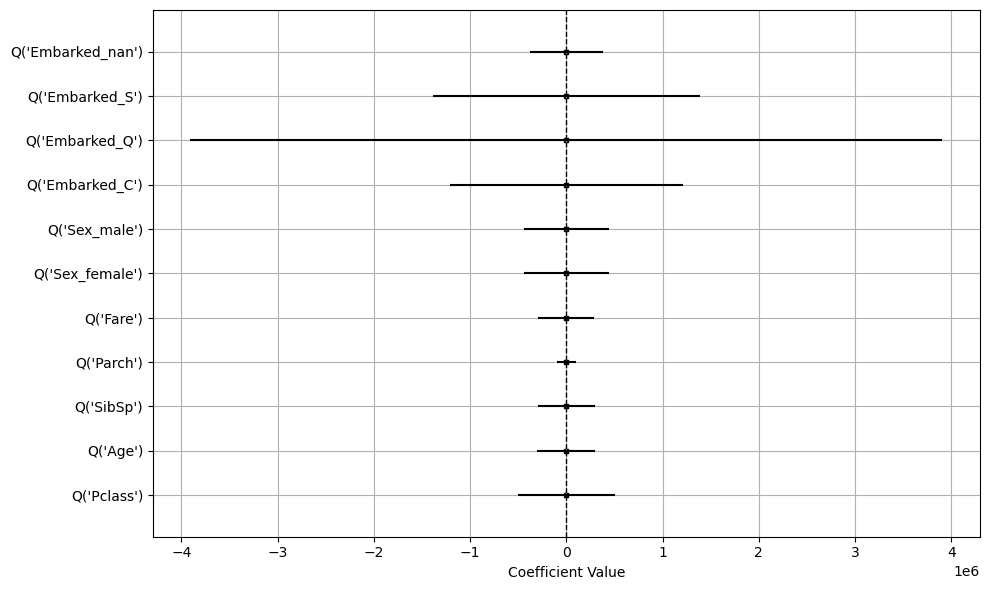

In [30]:
# Analyze coefficients of the logistic regression model
err_series = logistic.params - logistic.conf_int()[0]
coef_df = pd.DataFrame({
    'coef': pd.to_numeric(logistic.params.values[1:], errors='coerce'),
    'err': pd.to_numeric(err_series.values[1:], errors='coerce'),
    'varname': err_series.index.values[1:]
})

# Plot coefficient values with error bars
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(coef_df['varname'], coef_df['coef'], xerr=coef_df['err'], color='none', edgecolor=None)
ax.scatter(y=coef_df['varname'], x=coef_df['coef'], marker='s', s=10, color='black')
ax.axvline(x=0, linestyle='--', color='black', linewidth=1)

ax.set_xlabel('Coefficient Value')
ax.set_ylabel('')
ax.grid(True)

plt.tight_layout()
plt.show()

### Analyze the Surrogate Model's Effectiveness and Discuss When Such Approximations Are Helpful

The surrogate model, represented by a generalized linear model (GLM) trained on the predictions of the neural network, demonstrates perfect accuracy in approximating the neural network’s predictions, as indicated by an accuracy score of 1.0. This highlights its ability to capture the behavior of the original neural network for the Titanic dataset. However, a deeper examination of the coefficient values provides nuanced insights into its interpretability and limitations.

#### Coefficients and Interpretability
The coefficient plot shows the relative contributions of each feature to the neural network's predictions as approximated by the GLM. For instance, the coefficients for `Sex_female` (348.42) and `Sex_male` (-348.42) suggest that gender plays a critical role in survival predictions, reflecting real-world rescue priorities where women were prioritized. Similarly, `Fare` has a positive coefficient (158.78), indicating that passengers who paid higher fares (likely in higher classes) were more likely to survive, aligning with historical accounts of class-based rescue advantages.

Conversely, features such as `Pclass` (-387.28), `Age` (-238.31), and `SibSp` (-229.54) exhibit significant negative coefficients, suggesting that older passengers, individuals in lower classes, and those with more siblings or spouses onboard had reduced survival probabilities. These findings align with historical trends and the model's learned patterns. Features such as `Embarked` and `Parch` have smaller coefficients, indicating weaker or more context-dependent relationships with survival outcomes.

#### Limitations of the Surrogate Model
While the surrogate model achieves perfect accuracy in approximating the neural network, its reliance on linear relationships may oversimplify complex interactions present in the original model. For example, the neural network might capture non-linear dependencies or interactions between features like `Pclass` and `Fare` that are not represented in the GLM. This limitation is particularly evident in features with near-zero or statistically insignificant coefficients, such as `Embarked` and `Parch`, which might have more nuanced effects in the neural network.

The extreme magnitude of some coefficients, coupled with their wide confidence intervals, highlights another limitation. These values suggest potential instability or overfitting in the surrogate model, where the coefficients may be sensitive to small changes in the data or the training process.

#### Usefulness of Surrogate Models
Despite its limitations, the GLM surrogate provides valuable interpretability for understanding the neural network's behavior. It allows for clear visualization of feature importance and directionality, making it easier to communicate insights to stakeholders. This is particularly useful in contexts where explainability is critical, such as compliance or ethical decision-making.

However, care must be taken to acknowledge the trade-offs involved. The surrogate model provides a simplified view of the neural network's behavior and may not capture all interactions or non-linearities. As such, it should be complemented with other interpretability techniques, such as PDPs, ICE plots, or ALE plots, to gain a more comprehensive understanding of the model.

#### Conclusion
The surrogate model effectively captures the general trends in the neural network's predictions while providing interpretable insights into feature contributions. It is a powerful tool for distilling complex model behavior into accessible and actionable information. However, its simplifications and potential limitations must be carefully communicated to ensure that stakeholders do not misinterpret its findings. By combining surrogate modeling with other interpretability techniques, a more holistic understanding of the model can be achieved.